<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/Experiment_with_the_horse_or_human_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Licensed under the Apache License, Version 2.0;

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-01-02 06:24:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   170MB/s    in 0.8s    

2021-01-02 06:24:59 (170 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

우리들에게는  '말' directory와 '사람' directory가 있다.  
Image Generator는 코딩 단계를 줄여 이미지에 적절한 라벨을 표시해주는 기능을 한다.  
  
directory 정의 및 아래 코드들을 실행해보자.

In [3]:
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

print(train_horse_names[:10])
print(train_human_names[:10])

['horse15-6.png', 'horse35-9.png', 'horse30-5.png', 'horse37-5.png', 'horse49-0.png', 'horse13-8.png', 'horse50-6.png', 'horse08-8.png', 'horse03-4.png', 'horse31-5.png']
['human11-04.png', 'human03-30.png', 'human06-20.png', 'human09-19.png', 'human11-01.png', 'human06-29.png', 'human09-16.png', 'human03-02.png', 'human17-26.png', 'human15-04.png']


In [5]:
print('total training horse images : ', len(os.listdir(train_horse_dir)))
print('total training human images : ', len(os.listdir(train_human_dir)))

total training horse images :  500
total training human images :  527


사진이 어떻게 생겼는지 확인하기 위해서 몇 장의 사진들을 먼저 확인해보자.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

8개의 말 사진과 8개의 사람 사진을 하나의 batch로 묶어서 실행하도록 하자.  
batch의 크기의 경우 cell을 다시 실행하여 원하는 크기로 수정할 수 있다.

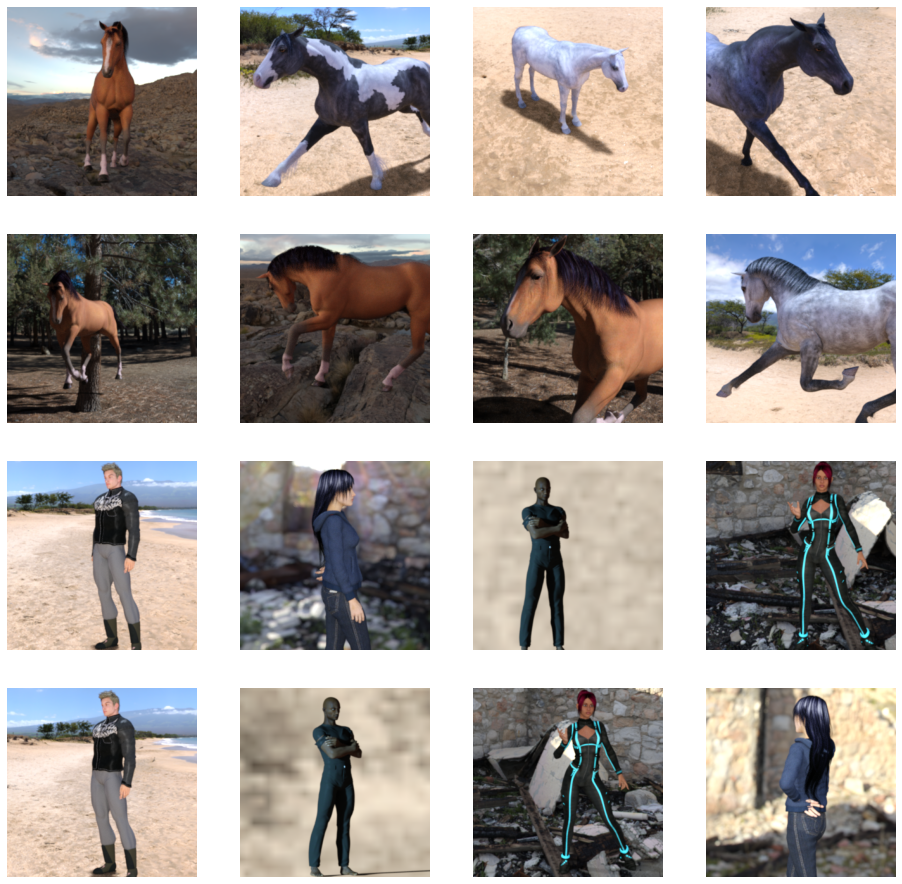

In [7]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix + next_human_pix) :
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Building a Small Model from Scratch

In [8]:
import tensorflow as tf
from tensorflow import keras
import keras as kr

In [9]:
model = kr.models.Sequential([
    kr.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (300, 300, 3)),
    kr.layers.MaxPooling2D(2,2),

    kr.layers.Conv2D(32, (3,3), activation = 'relu'),
    kr.layers.MaxPooling2D(2,2),

    kr.layers.Conv2D(64, (3,3), activation = 'relu'),
    kr.layers.MaxPooling2D(2,2),

    kr.layers.Conv2D(64, (3,3), activation = 'relu'),
    kr.layers.MaxPooling2D(2,2),

    kr.layers.Conv2D(64, (3,3), activation = 'relu'),
    kr.layers.MaxPooling2D(2,2),

    kr.layers.Flatten(),
    kr.layers.Dense(512, activation = 'relu'),
    kr.layers.Dense(1, activation = 'sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

Binary Classification의 경우 더 유용한 `binary_crossentropy`를 사용할 것이고 activation function 역시 `sigmoid`를 사용할 것이다. 더불어 optimizer도 learning rate를 `0.001`로 하는 `rmsporp`을 이용해보도록 할 것이다.

In [11]:
from tensorflow.keras.optimizers import RMSprop

In [12]:
model.compile(optimizer = RMSprop(lr = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Data Preprocessing

* 0과 1사이의 값으로 정규화를 시켜줄 것이다.
* kras의 `ImageDataGenerator`를 사용하여 `.flow(data, labels)` 또는 `.flow_from_directory(directory)`를 통해 augemnted image batches의 생정자들을 인스턴스화 시킬 수 있다.
* 바로 앞의 생성자들은 `fit`, `evaluate_generator`, 'predict_generator`들과 함꼐 사용되어질 수 있다.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.


## Training

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 15,
    verbose = 1
)

Epoch 1/15
8/8 [==============================] - 15s 798ms/step - loss: 0.9462 - accuracy: 0.5110
Epoch 2/15
8/8 [==============================] - 7s 888ms/step - loss: 0.8145 - accuracy: 0.5908
Epoch 3/15
8/8 [==============================] - 6s 780ms/step - loss: 0.8230 - accuracy: 0.6074
Epoch 4/15
8/8 [==============================] - 6s 761ms/step - loss: 0.5292 - accuracy: 0.7379
Epoch 5/15
8/8 [==============================] - 6s 758ms/step - loss: 0.2983 - accuracy: 0.8670
Epoch 6/15
8/8 [==============================] - 6s 756ms/step - loss: 0.2595 - accuracy: 0.8827
Epoch 7/15
8/8 [==============================] - 6s 774ms/step - loss: 0.3516 - accuracy: 0.8979
Epoch 8/15
8/8 [==============================] - 6s 905ms/step - loss: 0.1371 - accuracy: 0.9575
Epoch 9/15
8/8 [==============================] - 6s 774ms/step - loss: 0.0607 - accuracy: 0.9748
Epoch 10/15
8/8 [==============================] - 6s 778ms/step - loss: 0.0966 - accuracy: 0.9632
Epoch 11/15
8/8 [=

## Running the Model

아래의 코드는 우리가 1개 혹은 더 많은 file들을 file system에서 고를 수 있게 해주고 그걸 upload하는 기능을 한다.

In [15]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys() :

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, path, target_size = (300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(classes[0])

  if classes[0] > 0.5 :
    print(fn + ' is a human')
  else :
    print(fn + ' is a horse')

Saving worried-girl-413690_640.jpg to worried-girl-413690_640.jpg
[1.]
worried-girl-413690_640.jpg is a human


## Visualizing Intermediate Representations

* Convnet을 통과할 때 어떻게 변형되는지 시각화해보도록 하자.
* training set에서 랜덤으로 하나를 선택해서 각 행이 한 layer의 출력물이고 그 행의 각 이미지들이 출력물의 특징 map인 특정 filter이다.
* 다양한 training images들로 시도하여 확인해보도록 하자.

In [17]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


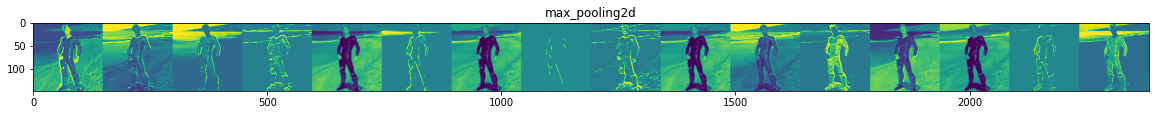

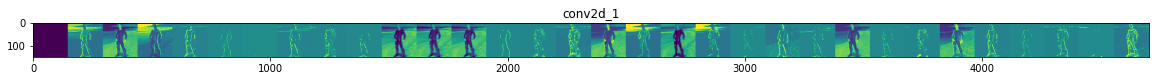

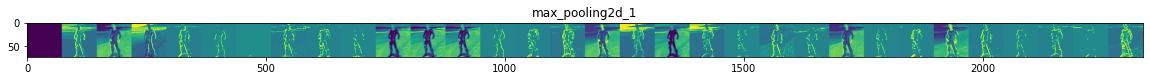

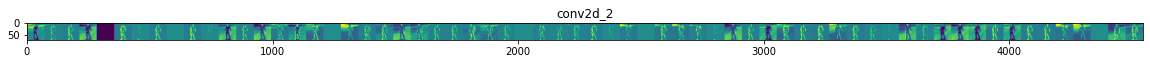

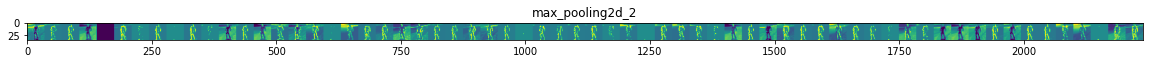

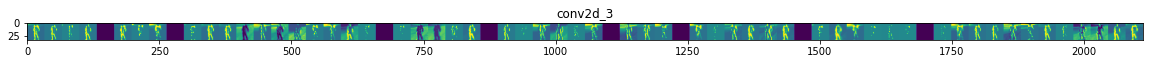

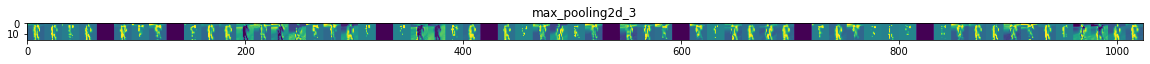

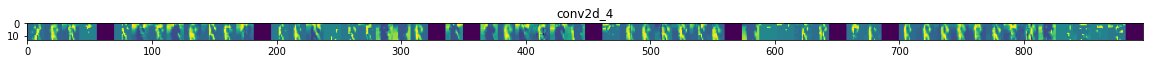

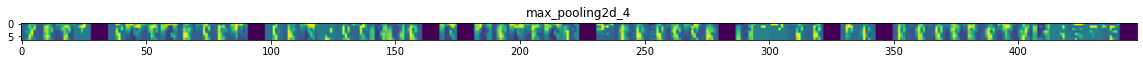

In [22]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = kr.models.Model(inputs = model.input, outputs = successive_outputs)

horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size = (300, 300))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

x /= 255

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps) :

  if len(feature_map.shape) == 4 :
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features) :
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')    
      display_grid[:, i * size : (i+1) * size] = x

    scale = 20. / n_features
    
    plt.figure(figsize = (scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

* 위의 그림처럼, 처음 pixel에서부터 점점 더 추상적이고 컴팩트한 pixel로 바뀐다.
* downstream은 network이 주목하는 것을 강조하고, 이들은 'activated'되는 특징을 더 적게 보여준다.
* 대부분은 0으로 설정된다. 이것이 **sparsity**이며 **딥러닝의 핵심 특징**이다.
* 이 특징은 이미지의 original pixel에 대한 정보를 점점 더 적게 전달하지만 이미지의 class에 대한 정보는 점점 더 세분화된다.
* 즉, Information distillation pipeline으로서 convnet을 생각할 수 있다.

# Clean up

다음을 복사하여 위와 같은 cell들을 실행했을 때 메모리확보를 위해 실항하고 마무리하도록 하자. (colab을 이용할 때 해당된다.)

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)